# Reglas de asociación

Hay que buscar reglas de asociación sobre el conjunto de datos de recetas de cocina de este [link](https://projet.liris.cnrs.fr/ccc/ccc2011/doku.php).

In [1]:
import re

import xml.etree.ElementTree

# import nltk
# nltk.download('stopwords')
# nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer

import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (12, 8)

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules

# Lectura y limpieza de datos

Leemos el fichero **recipeBaseCompulsory_clean.xml** y parseamos el XML guardando el título de la receta y sus ingredientes.

In [2]:
e = xml.etree.ElementTree.parse('datasets/recipeBaseCompulsory_clean.xml').getroot()

recipe_ingredients = []
recipe_title = []

for atype in e.findall('RECIPE'):
    ingredients = []
    
    recipe_title.append(atype.find('TI').text)
    
    for i in atype.findall('IN'):
        try:
            ingredients.append(i.text)
        except Exception:
            pass
    
    recipe_ingredients.append(ingredients)

<br>

Todas las recetas han sido escritas a mano, por lo que es necesario realizar minería de texto para eliminar palabras innecesarias (**stopwords**), signos de puntuación, números y coger únicamente las palabras que hacen referencia a alimentos. Para ello, se va a utilizar el paquete **nltk**, el cual ya viene con un listado de **stopwords** al que se añadirán otras palabras referentes a medidas de peso, tamaño o temperatura para quedarnos únicamente con los alimentos.

In [3]:
tokenizer = RegexpTokenizer(r'\w+')
stop_words = stopwords.words("english") 
stop_words.extend(['ounce', 'skinless', 'boneless', 'halves', 'cold', 'sized',
                   'cooked', 'unseasoned', 'colored', 'light', 'medium', 'thinly',
                   'coarsely', 'crushed', 'whole', 'recipe', 'pitted', 'bing'])

recipe_ingredients_clean = []
recipe_title_clean = []

for rec_tit in recipe_title:
    t = rec_tit.lower()
    words = tokenizer.tokenize(t)

    recipe_title_clean.append(' '.join([word for word in words 
                                       if word not in stop_words
                                       and not word.isdigit() 
                                       and len(word) > 3]))

recipe_title_clean = list(filter(None, recipe_title_clean))

    
for rec_ing in recipe_ingredients:
    ingredients_clean = []
    
    for ing in rec_ing:
        t = ing.lower()
        t = re.sub("[\(\[].*?[\)\]]", "", t) # Remove brackets
        t = t.split(',')[0]
        t = t.split(';')[0]
        t = t.split(' or ')[0]

        words = tokenizer.tokenize(t)

        ingredients_clean.append(' '.join([word for word in words 
                                           if word not in stop_words
                                           and not word.isdigit() 
                                           and len(word) > 3]))
        
    ingredients_clean = list(set(filter(None, ingredients_clean)))
    recipe_ingredients_clean.append(ingredients_clean)

<br>

Mostramos los ingredientes de las 5 primeras recetas parseadas:

In [4]:
recipe_ingredients_clean[:5]

[['oranges', 'saladitos', 'apples', 'lemons', 'dill pickles'],
 ['basil',
  'hamburger',
  'cloves garlic',
  'corn',
  'kidney beans',
  'favorite seasonings',
  'onion',
  'mild',
  'pepper',
  'mushrooms',
  'uncooked pasta',
  'italian seasoning',
  'tomato sauce'],
 ['ground pork',
  'lean beef brisket',
  'onions',
  'cloves garlic',
  'tomatoes',
  'salt',
  'tequila',
  'mustard',
  'oregano',
  'beef bouillon cubes',
  'cumin',
  'beer',
  'green chiles',
  'chili powder',
  'tomato sauce'],
 ['hidden valley ranch dressing',
  'following vegetables',
  'cream cheese',
  'crescent rolls',
  'mayo'],
 ['butter',
  'powdered sugar',
  'eggs',
  'cream cheese',
  'canned filling',
  'sugar',
  'graham cracker crumbs',
  'vanilla',
  'sour cream']]

<br>

Guardamos en CSV los ingredientes de las recetas en forma de transacciones.

In [5]:
pd.DataFrame(recipe_ingredients_clean).to_csv('datasets/recipe_ingredients_transactions.csv', sep=';', 
                                              header=False, index=False, na_rep=None)

<br>
# Funciones para itemsets frecuentes y reglas de asociación

Se han implementado en Python las funciones de R **itemFrequencyPlot**, del paquete **arules**, y **plot()**, del paquete **arulesViz**.

---
```R
itemFrequencyPlot(Adult, support = 0.1, cex.names = 0.8, topN = NULL)
```
---

---
```R
plot(rules2, measure = c("support", "confidence"), shading = "lift") 
```
---

In [6]:
def item_frequency_plot(df_transactions, support=0, top_n=None, ticks_fontsize=12):
    frequent_itemsets = apriori(df_transactions, 
                                min_support=support, 
                                use_colnames=True)
    
    frequent_itemsets = frequent_itemsets.sort_values('support', ascending=False)
    
    if top_n:
        frequent_itemsets = frequent_itemsets.head(top_n)
        
    
    fig = frequent_itemsets.plot('itemsets',
                                 'support',
                                 kind='bar',
                                 fontsize=ticks_fontsize,
                                 legend=False,
                                 title='Item Frequency', 
                                 colormap='GnBu_r')
    fig.set_ylabel("Support", fontsize=12)
    fig.set_xlabel("Itemsets", fontsize=12)

In [7]:
def assoc_rules_plot(assoc_rules, measure=('support', 'confidence'), shading=None):
    X = assoc_rules[measure[0]]
    y = assoc_rules[measure[1]]
    
    c = 'r'
    cmap = None
    if shading:
        c = assoc_rules[shading]
        cmap = 'Reds'
    
    plt.scatter(X, y, c=c, cmap=cmap)
    plt.xlabel(measure[0])
    plt.ylabel(measure[1])
    
    if shading:
        col_bar = plt.colorbar()
        col_bar.ax.set_title(shading)

<br>
# Reglas de asociación

Una regla de asociación busca regularidades en los datos. Intenta asociar datos, objetos, eventos... que aparecen juntos para buscar patrones, asociaciones o correlaciones.

El recuento ($\sigma$) es el número de veces que aparece un itemset en el dataset.

<br>

El soporte de la regla ($s$) es la probabilidad de que una transacción contenga a $X$ y a $Y$:

$$ s(X \rightarrow Y) = \frac{\sigma(X, Y)}{T} $$

<br>

La confianza de la regla ($c$) es la probabilidad de que una transacción que contenga a $X$ también contenga a $Y$:

$$ c(X \rightarrow Y) = \frac{\sigma(X, Y)}{\sigma(X)} = \frac{s(X, Y)}{s(X)}$$

<br>

El *lift* es una medida de correlación que mide cuan alejados están los itemsets de la independencia:

$$ lift(X \rightarrow Y) = \frac{s(X, Y)}{s(X) \ s(Y)}$$

* Si $lift(X \rightarrow Y) < 1$, la ocurrencia de X está negativamente correlacionada con la ocurrencia de Y.

* Si $lift(X \rightarrow Y) > 1$, X e Y están positivamente correlacionadas.

* Si $lift(X \rightarrow Y) = 1$, X e Y son idependientes.

<br>

*Conviction* mide las veces que A ocurre sin B:

$$ conv(X \rightarrow Y) = \frac{1 - s(Y)}{1 - c(X \rightarrow Y)} $$

<br>

El algoritmo Apriori sirve para reducir los candidatos a itemset frecuente. Se basa en la propiedad de que si un itemset no es frecuente, tampoco lo serán sus supersets; mientras que si un itemset es frecuente, también lo serán sus subconjuntos.

<br>

El paquete **mlxtend** puede encontrar reglas de asociación con las funciones **apriori()** [[1]](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/apriori/) y **association_rules()** [[2]](http://rasbt.github.io/mlxtend/user_guide/frequent_patterns/association_rules/). La primera encuentra los itemsets frecuentes y la segunda genera las reglas de asociación a partir de los itemsets frecuentes. En R esto se puede hacer en conjunto con la siguiente función:

---
```R
freq_itemsets = apriori(data_trans, parameter=list(support=0.03, confidence=0.6,
                                                   minlen=1, maxlen=1000,
                                                   target='rules'))
```
---

<br>
No obstante, si lo que se desea encontrar en R es únicamente los itemsets frecuentes, se hace de la siguiente manera:

---
```R
assoc_rules = apriori(data_trans, parameter=list(support=0.03, minlen=1, maxlen=1000,
                                                 target='frequent itemsets'))
```
---

<br>

Una diferencia del paquete **mlxtend** de Python con el **arules** de R es que, este último, solo encuentra reglas de asociación con itemsets de tamaño uno en su consecuente, mientras que el primero las encuentra con itemsets de cualquier tamaño.

<br>
## Reglas de asociación con todas las recetas

Es necesario convertir el listado de ingredientes visto anteriormente en transacciones. El paquete **mlxtend** tiene la clase **TransactionEncoder()** para convertir el listado en un dataframe *one-hot*.

In [8]:
te = TransactionEncoder()
te_ary = te.fit_transform(recipe_ingredients_clean)

df_transactions = pd.DataFrame(te_ary, columns=te.columns_)
df_transactions.head()

,accent,acorn squash,across bone inch thick,acrylic paints,active dried yeast,active yeast,active yeast star,active yeast warm water,acuavit,additional butter,...,zampone sausage,zest,zinfandel reduction sauce,zinfandel wine,ziti,zucchini,zucchini pieces,zucchini sliced rings,zucchinis,zuchinni
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


<br>

Calculamos los itemsets con soporte mínimo de 0.03, mostrando únicamente los 40 con mayor soporte:

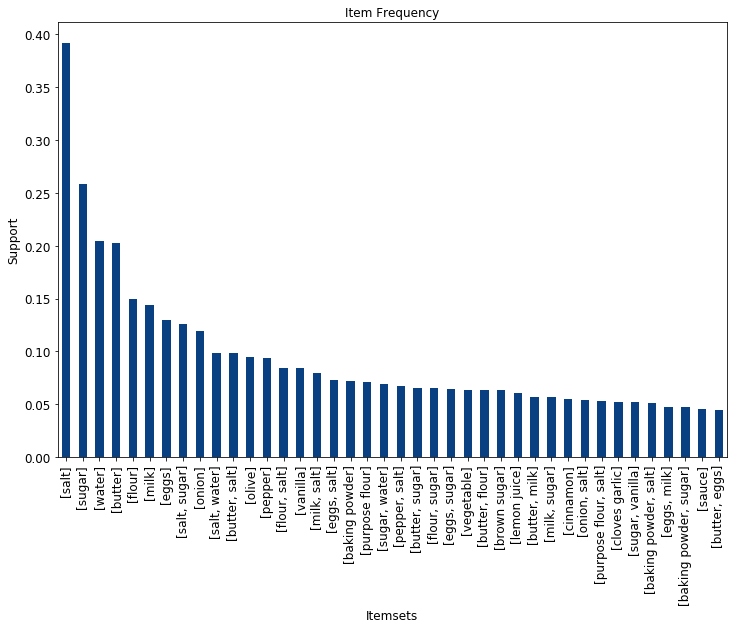

In [9]:
item_frequency_plot(df_transactions, support=0.03, top_n=40)

<br>



Sal, azúcar, agua, mantequilla, harina, leche y huevos son los ingredientes más utilizados en las recetas  del dataset.

A continuación, se van a buscar reglas de asociación con soporte mínimo de 0.005 y sin valor mínimo en la confianza. De esta forma, encontraremos prácticamente todas las reglas del dataset y se podrá generar un gráfico para ver cómo se distribuyen según el soporte, la confianza y el *lift*.

In [10]:
frequent_itemsets = apriori(df_transactions, min_support=0.005, use_colnames=True)
assoc_rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0)

print('Número de reglas de asociación encontradas con min_support = 0.005:', len(assoc_rules))

Número de reglas de asociación encontradas con min_support = 0.005: 5212


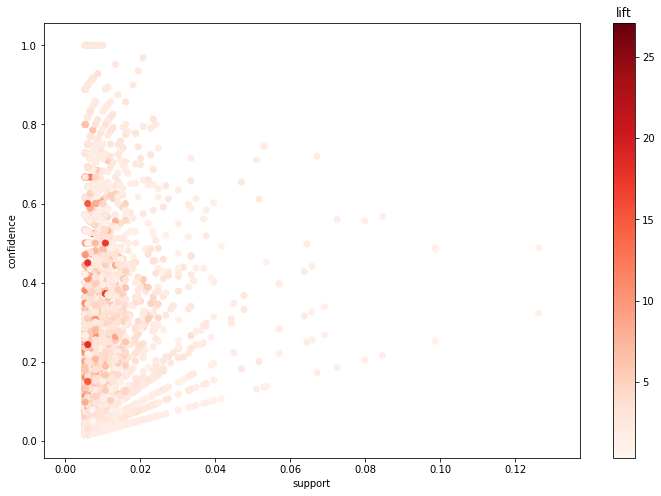

In [11]:
assoc_rules_plot(assoc_rules, shading='lift')

<br>

En la anterior gráfica se puede apreciar como el soporte es bajo en general, entre 0.01 y 0.03, y la mayoría de reglas tienen un soporte inferior al 0.8. Las reglas con itemsets más correlacionados (*lift*) son las que se encuentran con un soporte de alrededor del 0.01 y una confianza de entre 0.3 y 0.6.

Las 15 reglas de asociación encontradas y ordenadas según su soporte y confianza son las siguientes:

In [12]:
assoc_rules.sort_values(['support', 'confidence'], ascending=False).head(15)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1428,(sugar),(salt),0.258563,0.391538,0.126259,0.488312,1.247163,0.025022,1.189126
1429,(salt),(sugar),0.391538,0.258563,0.126259,0.322470,1.247163,0.025022,1.094324
4060,(butter),(salt),0.202149,0.391538,0.098724,0.488372,1.247317,0.019575,1.189267
770,(water),(salt),0.204164,0.391538,0.098724,0.483553,1.235008,0.018786,1.178169
771,(salt),(water),0.391538,0.204164,0.098724,0.252144,1.235008,0.018786,1.064157
4061,(salt),(butter),0.391538,0.202149,0.098724,0.252144,1.247317,0.019575,1.066851
4018,(flour),(salt),0.149093,0.391538,0.084621,0.567568,1.449585,0.026245,1.407069
4019,(salt),(flour),0.391538,0.149093,0.084621,0.216123,1.449585,0.026245,1.085511
2416,(milk),(salt),0.143721,0.391538,0.079919,0.556075,1.420232,0.023647,1.370641
2417,(salt),(milk),0.391538,0.143721,0.079919,0.204117,1.420232,0.023647,1.075886


<br>

Las 15 reglas de asociación con mayor confianza independientemente de su soporte son:

In [13]:
assoc_rules.sort_values('confidence', ascending=False).head(15)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
3796,"(purpose flour, milk, baking powder)",(salt),0.010074,0.391538,0.010074,1.0,2.554031,0.006130,inf
2278,"(sugar, water, baking powder)",(salt),0.006716,0.391538,0.006716,1.0,2.554031,0.004086,inf
5016,"(baking powder, purpose flour, sugar, vanilla)",(salt),0.005373,0.391538,0.005373,1.0,2.554031,0.003269,inf
1542,"(baking powder, purpose flour, vanilla)",(salt),0.006716,0.391538,0.006716,1.0,2.554031,0.004086,inf
1688,"(water, onions)",(salt),0.009402,0.391538,0.009402,1.0,2.554031,0.005721,inf
3534,"(cocoa, baking powder)",(salt),0.005373,0.391538,0.005373,1.0,2.554031,0.003269,inf
528,"(sugar, yeast, milk)",(salt),0.005373,0.391538,0.005373,1.0,2.554031,0.003269,inf
2650,"(bread flour, milk)",(salt),0.005373,0.391538,0.005373,1.0,2.554031,0.003269,inf
3266,"(purpose flour, sugar, eggs, baking powder)",(salt),0.008059,0.391538,0.008059,1.0,2.554031,0.004904,inf
2312,"(purpose flour, eggs, baking powder)",(salt),0.009402,0.391538,0.009402,1.0,2.554031,0.005721,inf


<br>

Podemos observar que la sal y el azúcar se encuentran en la mayoría de los consecuentes de las reglas debido a que se encuentran en el 40% y 25%, respectivamente, de las recetas del dataset. Los itemsets de las reglas mostradas están correlacionadas ya que $lift > 1$.

<br>
## Reglas de asociación con recetas de pescado

Para poder encontrar las recetas de pescado, se ha buscado en los títulos las palabras de la lista **fish_words**.

In [14]:
fish_words = ['fish', 'seafood', 'snapper', 'tuna', 'bluefish', 
              'shark', 'croaker', 'flounder', 'trout']

fish_recipes_idx = [i for i, e in enumerate(recipe_title_clean) for x in fish_words if x in e]
fish_recipes_ingredients = list(np.asarray(recipe_ingredients_clean)[fish_recipes_idx])

print('Número de recetas de pescado:', len(fish_recipes_ingredients))

Número de recetas de pescado: 46


<br>

Guardamos en CSV los ingredientes de las recetas de pescado en forma de transacciones.

In [15]:
pd.DataFrame(fish_recipes_ingredients).to_csv('datasets/fish_recipes_transactions.csv', sep=';', 
                                              header=False, index=False, na_rep=None)

<br>

Convertimos el listado de ingredientes de recetas de pescado en transacciones.

In [16]:
te = TransactionEncoder()
te_ary = te.fit_transform(fish_recipes_ingredients)

df_fish_transactions = pd.DataFrame(te_ary, columns=te.columns_)

<br>

Y mostramos los itemsets más frecuentes para estas recetas.

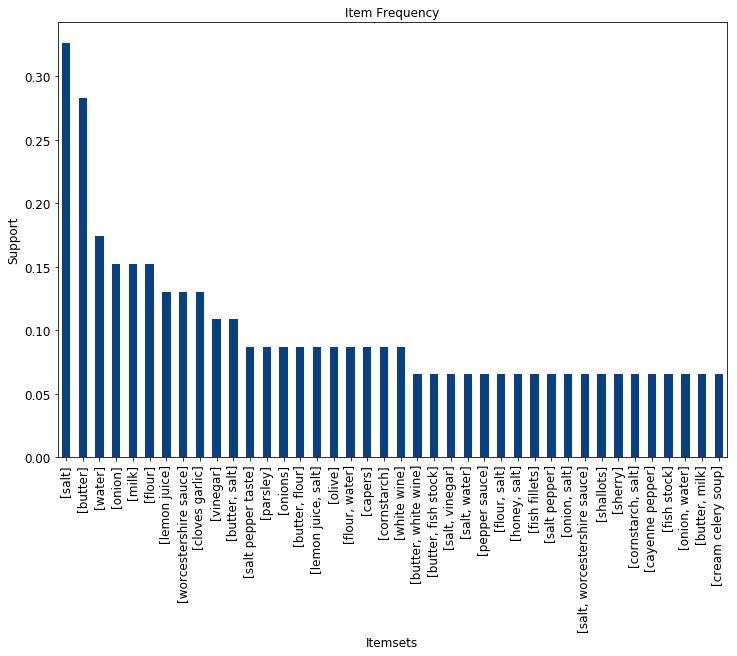

In [17]:
item_frequency_plot(df_fish_transactions, support=0.03, top_n=40)

<br>

Podemos observar que la sal, la mantequilla, el agua, la leche y la harina siguen siendo los ingredientes más frecuentes. Además, ingredientes como el zumo de limón, las cebollas o el vinagre se encuentran más frecuentemente en recetas de pescado que en el resto de recetas.

In [18]:
fish_frequent_itemsets = apriori(df_fish_transactions, min_support=0.03, use_colnames=True)
fish_assoc_rules = association_rules(fish_frequent_itemsets, metric="confidence", min_threshold=0)

print('Número de reglas de asociación encontradas con min_support = 0.03:', len(fish_assoc_rules))

Número de reglas de asociación encontradas con min_support = 0.03: 7134


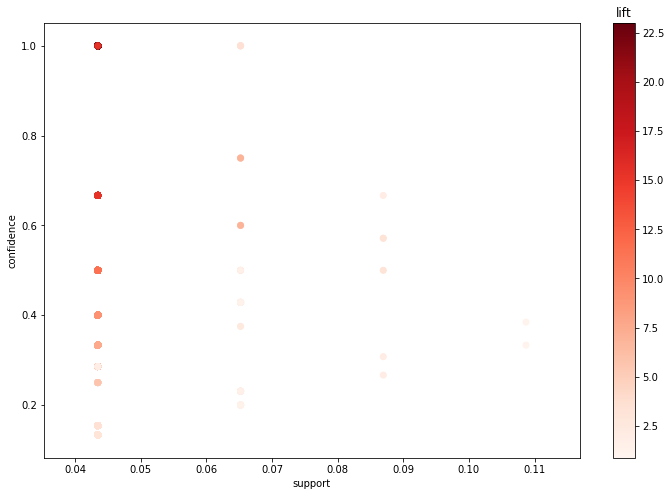

In [19]:
assoc_rules_plot(fish_assoc_rules, shading='lift')

<br>

En este caso las reglas de asociación encontradas no forman una nube de puntos como hemos visto con todo el conjunto de datos, sino que están dispersas en 3 grupos de valores de soporte (0.043, 0.065 y 0.087). Las reglas con soporte más bajo y confianza más alta son las que tienen un *lift* mayor.

A continuación, se muestran las 15 primeras reglas de asociación ordenadas por el soporte y la confianza:

In [20]:
fish_assoc_rules.sort_values(['support', 'confidence'], ascending=False).head(15)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1302,(butter),(salt),0.282609,0.326087,0.108696,0.384615,1.179487,0.016541,1.095109
1303,(salt),(butter),0.326087,0.282609,0.108696,0.333333,1.179487,0.016541,1.076087
2135,(lemon juice),(salt),0.130435,0.326087,0.086957,0.666667,2.044444,0.044423,2.021739
2944,(flour),(butter),0.152174,0.282609,0.086957,0.571429,2.021978,0.043951,1.673913
5072,(flour),(water),0.152174,0.173913,0.086957,0.571429,3.285714,0.060491,1.927536
5073,(water),(flour),0.173913,0.152174,0.086957,0.500000,3.285714,0.060491,1.695652
2945,(butter),(flour),0.282609,0.152174,0.086957,0.307692,2.021978,0.043951,1.224638
2134,(salt),(lemon juice),0.326087,0.130435,0.086957,0.266667,2.044444,0.044423,1.185771
345,(leaf),(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf
490,(fish stock),(butter),0.065217,0.282609,0.065217,1.000000,3.538462,0.046786,inf


<br>

Y en este caso ordenadas por confianza y, luego, soporte:

In [21]:
fish_assoc_rules.sort_values(['confidence', 'support'], ascending=False).head(15)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
345,(leaf),(butter),0.065217,0.282609,0.065217,1.0,3.538462,0.046786,inf
490,(fish stock),(butter),0.065217,0.282609,0.065217,1.0,3.538462,0.046786,inf
1022,(honey),(salt),0.065217,0.326087,0.065217,1.0,3.066667,0.043951,inf
2939,"(flour, salt)",(butter),0.065217,0.282609,0.065217,1.0,3.538462,0.046786,inf
0,"(worcestershire sauce, cornstarch, mustard)",(salt),0.043478,0.326087,0.043478,1.0,3.066667,0.029301,inf
1,"(worcestershire sauce, cornstarch, salt)",(mustard),0.043478,0.043478,0.043478,1.0,23.000000,0.041588,inf
2,"(worcestershire sauce, mustard, salt)",(cornstarch),0.043478,0.086957,0.043478,1.0,11.500000,0.039698,inf
3,"(cornstarch, mustard, salt)",(worcestershire sauce),0.043478,0.130435,0.043478,1.0,7.666667,0.037807,inf
4,"(worcestershire sauce, cornstarch)","(mustard, salt)",0.043478,0.043478,0.043478,1.0,23.000000,0.041588,inf
5,"(worcestershire sauce, mustard)","(cornstarch, salt)",0.043478,0.065217,0.043478,1.0,15.333333,0.040643,inf


<br>



# Una de sal y otra de azúcar

In [83]:
salt_sugar_rules = assoc_rules[(assoc_rules.antecedants.astype('str').str.contains('salt')) & 
                               (assoc_rules.consequents.astype('str').str.contains('sugar'))]

salt_sugar_rules.sort_values(['support', 'confidence'], ascending=False).head(30)

,antecedants,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
1429,(salt),(sugar),0.391538,0.258563,0.126259,0.322470,1.247163,0.025022,1.094324
380,"(butter, salt)",(sugar),0.098724,0.258563,0.039624,0.401361,1.552275,0.014098,1.238537
383,(salt),"(sugar, butter)",0.391538,0.065816,0.039624,0.101201,1.537631,0.013854,1.039369
3686,"(eggs, salt)",(sugar),0.072532,0.258563,0.037609,0.518519,2.005387,0.018855,1.539908
3689,(salt),"(sugar, eggs)",0.391538,0.064473,0.037609,0.096055,1.489851,0.012366,1.034938
2855,"(flour, salt)",(sugar),0.084621,0.258563,0.036938,0.436508,1.688209,0.015058,1.315790
2859,(salt),"(flour, sugar)",0.391538,0.065816,0.036938,0.094340,1.433385,0.011168,1.031495
2890,"(milk, salt)",(sugar),0.079919,0.258563,0.034923,0.436975,1.690014,0.014259,1.316881
2893,(salt),"(sugar, milk)",0.391538,0.057085,0.034923,0.089194,1.562466,0.012572,1.035253
430,"(baking powder, salt)",(sugar),0.051041,0.258563,0.033580,0.657895,2.544429,0.020382,2.167278
